In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
import glob
%matplotlib inline

- CITIbike is the largest bike sharing program in the United States. Bike stations are located across a large swath of New York City covering Manhattan, Brooklyn, Queens, the Bronx and even Jersey City. For many local New Yorkers it provides a fast and efficient means of commuting to work and for getting around the city. Given bike sharing as a key method of transportation, our analysis focused on how the COVID-19 pandemic impacted CITIbike ridership. 


# Apple Maps - Covid-19 Mobility Trends

Apple has compiled a dataset containing data on mobility trends across three methods of transportation - driving, transit, walking. Data includes daily changes in requests for directions from Apple Maps by transportation type for all available countries/regions, sub-regions, and cities - New York City being the focus of our analysis. Note from the source:  Data for May 11-12, 2020 and March 12, 2021 is not available and will appear as blank columns in the data set.


In [53]:
df2 = pd.read_csv('Data/apple_mobility_trends.csv',dtype={'geo_type': 'object',
 'region': 'object',
 'transportation_type': 'object',
 'alternative_name': 'object',
 'sub-region': 'object',
 'country': 'object'})

#filter to NYC and relevant columns, transpose
ny_df2 = df2[df2['region']=='New York City']
ny_df2_transposed = ny_df2.drop(['geo_type', 'region','alternative_name',
       'sub-region', 'country'], axis=1).T

#orient, set index to datetime for plotting
ny_df2_transposed = ny_df2_transposed.drop(ny_df2_transposed.index[0])
ny_df2_transposed.index = pd.to_datetime(ny_df2_transposed.index)

#set column names, make fields numeric
cols = ['driving', 'transit', 'walking']
ny_df2_transposed.columns = cols
ny_df2_transposed[cols] = ny_df2_transposed[cols].apply(pd.to_numeric, 
                                                        errors='coerce', axis=1)

In [54]:
#Date Range
print("Start Date:",ny_df2_transposed.index.min())
print("End Date:",ny_df2_transposed.index.max())
ny_df2_transposed.head()

Start Date: 2020-01-13 00:00:00
End Date: 2021-03-21 00:00:00


,driving,transit,walking
2020-01-13,100.00,100.00,100.00
2020-01-14,101.51,92.66,96.09
2020-01-15,104.51,95.29,105.77
2020-01-16,108.78,96.42,101.73
2020-01-17,122.44,107.50,117.09


### Descriptive Statistics

In [55]:
ny_df_mobility = ny_df2_transposed.copy()
ny_df_mobility.describe()

,driving,transit,walking
count,431.000000,431.000000,431.000000
mean,97.733387,49.058422,69.893387
std,26.404229,24.280821,25.941323
min,29.240000,11.250000,18.230000
25%,85.885000,37.090000,56.395000
50%,100.990000,47.320000,70.440000
75%,116.320000,54.485000,82.695000
max,152.090000,118.610000,153.650000


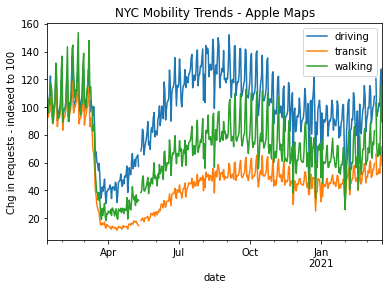

In [63]:
#plot trends

ax = ny_df_mobility.plot(title='NYC Mobility Trends - Apple Maps', figsize=(6,4))
ax.set_ylabel("Chg in requests - indexed to 100")
ax.set_xlabel("date")

plt.show()

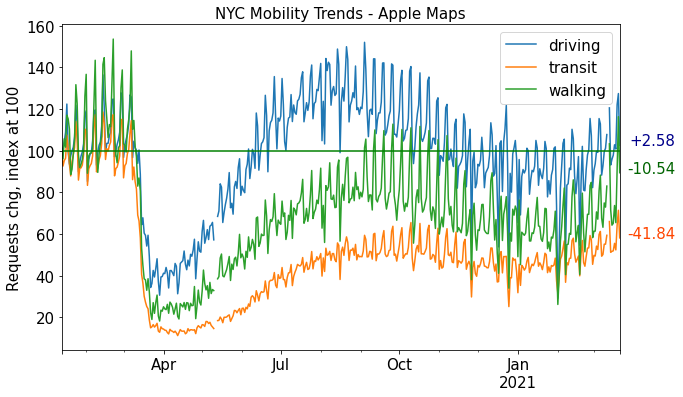

In [124]:
ax = ny_df_mobility.plot(y = ['driving','transit','walking'], figsize=(10,6), fontsize=15)
ax.set_ylabel("Requests chg, index at 100", fontsize=15)
ax.set_title('NYC Mobility Trends - Apple Maps', fontsize=15)
ax.legend(fontsize=15)


plt.annotate('+%0.2f' % ((100-ny_df_mobility.driving[-1])*-1), xy=(1, ny_df_mobility.driving[-1]), xytext=(10, 0), 
             xycoords=('axes fraction', 'data'), textcoords='offset points', color='darkblue', size=15)

plt.annotate('%0.2f' % ((100-ny_df_mobility.transit[-1])*-1), xy=(1, ny_df_mobility.transit[-1]), xytext=(8, 0), 
             xycoords=('axes fraction', 'data'), textcoords='offset points', color='orangered', size=15)

plt.annotate('%0.2f' % ((100-ny_df_mobility.walking[-1])*-1), xy=(1, ny_df_mobility.walking[-1]), xytext=(8, 0), 
             xycoords=('axes fraction', 'data'), textcoords='offset points', color='darkgreen', size=15)


plt.axhline(y=100, color='g', linestyle='-')

plt.show()


# NYtimes COVID cases by county

### Important dates to overlay
- On 22 March, New York state issued a stay-at-home order
- On 25 March, Citi Bike announced its Critical Workforce Membership Program
- On 30 April, Citi Bike extended and enhanced the program.

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv',
                 parse_dates=['date'])
ny_df = df[(df['county'] == 'New York City') & (df['date'] < '2021-03-21')]
ny_df = ny_df.drop(['county','state','fips'], axis=1)
ny_df = ny_df.set_index('date')

In [5]:
# convert cumulative data to day-over-day
ny_df_diff = ny_df.diff(periods=1)
ny_df_diff.iloc[0] = ny_df.iloc[0]

#negatives deaths in change data due to corrections
#replace with 0s for plotting
ny_df_diff['deaths'] = ny_df_diff['deaths'].clip(lower=0)

In [184]:
ny_df_diff.head()

,cases,deaths
date,,
2020-03-01,1.0,0.0
2020-03-02,0.0,0.0
2020-03-03,1.0,0.0
2020-03-04,0.0,0.0
2020-03-05,2.0,0.0


### Descriptive statistics

In [185]:
#Date Range
print("Start Date:",ny_df_diff.index.min())
print("End Date:",ny_df_diff.index.max())

Start Date: 2020-03-01 00:00:00
End Date: 2021-03-20 00:00:00


In [11]:
ny_df_diff.cases.max()

8021.0

In [6]:
ny_df_diff.describe()

,cases,deaths
count,385.000000,385.000000
mean,2063.015584,79.444156
std,1995.220837,164.872544
min,0.000000,0.000000
25%,355.000000,6.000000
50%,1072.000000,25.000000
75%,3704.000000,71.000000
max,8021.000000,1221.000000


In [7]:
#create 7-day moving average columns
ny_df_diff['cases_SMA_7'] = ny_df_diff.iloc[:,0].rolling(window=7).mean()
ny_df_diff['deaths_SMA_7'] = ny_df_diff.iloc[:,1].rolling(window=7).mean()

### Cases & Seven-day moving average

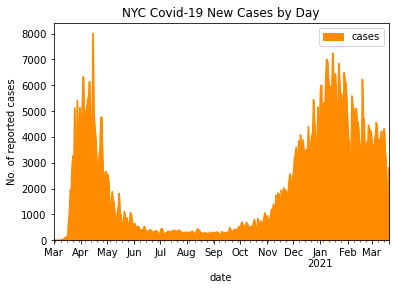

In [8]:
ax = ny_df_diff.plot.area(y='cases', title='NYC Covid-19 New Cases by Day', color='darkorange')
ax.set_ylabel("No. of reported cases")
plt.show()

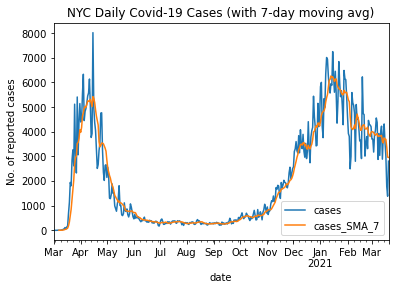

In [162]:
ax = ny_df_diff.plot(y=['cases','cases_SMA_7'],
                     title='NYC Daily Covid-19 Cases (with 7-day moving avg)')
ax.set_ylabel("No. of reported cases")
plt.show()

### Deaths & Seven-day moving average

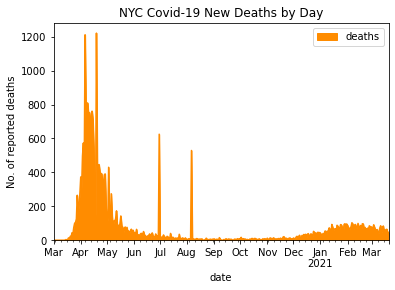

In [163]:
ax = ny_df_diff.plot.area(y='deaths', color='darkorange',title='NYC Covid-19 New Deaths by Day')
ax.set_ylabel("No. of reported deaths")
plt.show()

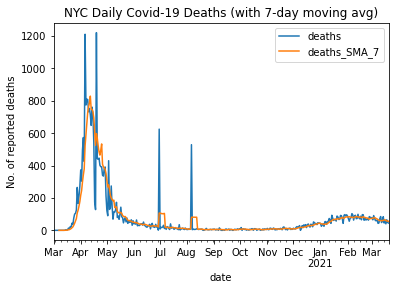

In [164]:
ax = ny_df_diff.plot(y=['deaths','deaths_SMA_7'],
                     title='NYC Daily Covid-19 Deaths (with 7-day moving avg)')
ax.set_ylabel("No. of reported deaths")
plt.show()

### Cases & Deaths Together

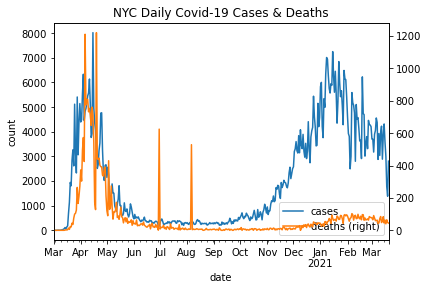

In [165]:
ax = ny_df_diff.plot(y='cases')
ax.set_ylabel("count")
ny_df_diff.plot(y='deaths',secondary_y=True, ax=ax, 
                title='NYC Daily Covid-19 Cases & Deaths')
plt.show()

In [223]:
ny_df_diff_monthly.index

DatetimeIndex(['2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
               '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31',
               '2020-11-30', '2020-12-31', '2021-01-31', '2021-02-28',
               '2021-03-31'],
              dtype='datetime64[ns]', name='date', freq='M')

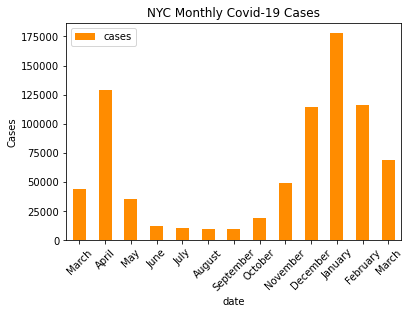

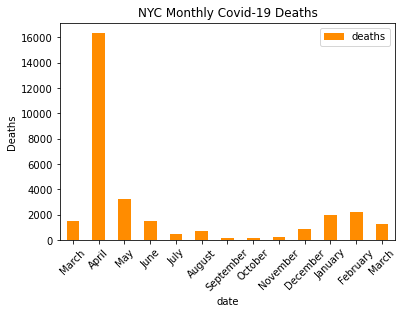

In [24]:
#Group by month

ny_df_diff_monthly = ny_df_diff.resample("M").sum()

ax = ny_df_diff_monthly.plot.bar(y='cases', 
                                 color='darkorange',
                                 title='NYC Monthly Covid-19 Cases', 
                                 rot=45)

ax.set_xticklabels(ny_df_diff_monthly.index.month_name())
ax.set_ylabel("Cases")

ax1 = ny_df_diff_monthly.plot.bar(y = 'deaths', color='darkorange', 
                                  title='NYC Monthly Covid-19 Deaths', 
                                  rot=45)
ax1.set_xticklabels(ny_df_diff_monthly.index.month_name())
ax1.set_ylabel("Deaths")

plt.show()

## Import CitiBike data

In [13]:
# Write the pattern to glob collection of csvs in data folder
pattern = '../../../data/*.csv'

# Save all file matches: csv_files
csv_files = glob.glob(pattern)
len(csv_files)

12

In [14]:
# Create an empty list: frames
frames = []

#  Iterate over csv_files
for csv in csv_files:
    df = pd.read_csv(csv, parse_dates=['starttime'])
    frames.append(df)

# Concatenate frames into a single DataFrame: bikes
bikes = pd.concat(frames)

print(bikes.shape)
bikes.head()

(18849408, 15)


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1062,2020-06-01 00:00:03.372,2020-06-01 00:17:46.2080,3419,Douglass St & 4 Ave,40.679279,-73.981540,3419,Douglass St & 4 Ave,40.679279,-73.981540,39852,Customer,1997,2
1,3810,2020-06-01 00:00:03.553,2020-06-01 01:03:33.9360,366,Clinton Ave & Myrtle Ave,40.693261,-73.968896,336,Sullivan St & Washington Sq,40.730477,-73.999061,37558,Subscriber,1969,0
2,1017,2020-06-01 00:00:09.614,2020-06-01 00:17:06.8330,389,Broadway & Berry St,40.710446,-73.965251,3562,Classon Ave & St Marks Ave,40.676520,-73.959608,37512,Customer,1988,2
3,226,2020-06-01 00:00:12.178,2020-06-01 00:03:58.8640,3255,8 Ave & W 31 St,40.750585,-73.994685,505,6 Ave & W 33 St,40.749013,-73.988484,39674,Customer,1969,0
4,1437,2020-06-01 00:00:21.255,2020-06-01 00:24:18.9650,367,E 53 St & Lexington Ave,40.758281,-73.970694,497,E 17 St & Broadway,40.737050,-73.990093,21093,Customer,1997,2


In [15]:
bikes_dates = bikes.loc[:,['starttime']]
bikes_dates.head()

,starttime
0,2020-06-01 00:00:03.372
1,2020-06-01 00:00:03.553
2,2020-06-01 00:00:09.614
3,2020-06-01 00:00:12.178
4,2020-06-01 00:00:21.255


In [16]:
bikes_dates['ride']=1
bikes_dates['starttime']= pd.to_datetime(bikes_dates.starttime)
bikes_dates['starttime'] = bikes_dates['starttime'].dt.strftime('%Y-%m-%d')
bikes_dates = bikes_dates.set_index('starttime',drop=True)
bikes_dates.head()

,ride
starttime,
2020-06-01,1
2020-06-01,1
2020-06-01,1
2020-06-01,1
2020-06-01,1


In [17]:
by_date = bikes_dates.groupby('starttime').count()

In [18]:
by_date.rename({'ride': 'ride_count'}, axis=1, inplace=True)
by_date.index = pd.to_datetime(by_date.index)
print(by_date.shape)
by_date.head()

(364, 1)


,ride_count
starttime,
2020-03-01,31878
2020-03-02,56946
2020-03-03,49723
2020-03-04,58670
2020-03-05,58686


In [19]:
by_date.describe().round(2)

,ride_count
count,364.00
mean,51784.09
std,24731.25
min,179.00
25%,30688.50
50%,51887.50
75%,72828.25
max,101462.00


In [280]:
by_date.to_csv('bikes_by_date.csv')

In [173]:
print("Start Date:",by_date.index.min())
print("End Date:",by_date.index.max())

Start Date: 2020-03-01 00:00:00
End Date: 2021-02-28 00:00:00


In [51]:
round(by_date.describe(),2)

,ride_count,ride_count_SMA_7
count,364.00,358.00
mean,51784.09,51973.11
std,24731.25,21767.74
min,179.00,14176.86
25%,30688.50,31223.57
50%,51887.50,52756.29
75%,72828.25,71437.29
max,101462.00,88405.71


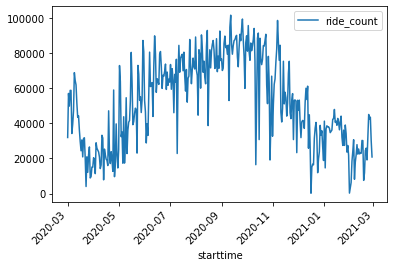

In [20]:
by_date.plot()
plt.xticks(rotation=45)
plt.show()

In [28]:
#add 7-day moving avg for rides
by_date['ride_count_SMA_7'] = by_date.iloc[:,0].rolling(window=7).mean()
by_date.tail()

,ride_count,ride_count_SMA_7
starttime,,
2021-02-24,44973,23754.285714
2021-02-25,42502,28756.714286
2021-02-26,43452,33281.000000
2021-02-27,30030,34075.000000
2021-02-28,20794,33357.857143


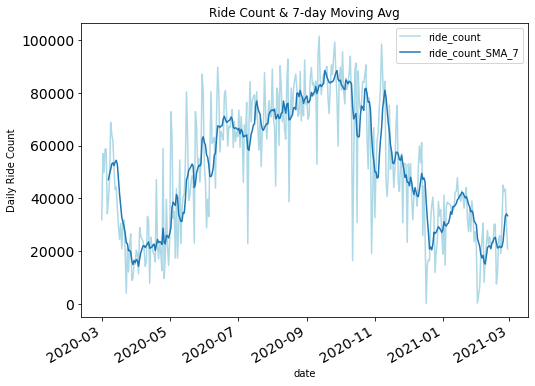

In [127]:
txt='Test'
ax = by_date.plot(y=['ride_count','ride_count_SMA_7'], color =['lightblue', 'tab:blue'],
             title='Ride Count & 7-day Moving Avg', figsize=(8,6), fontsize=14)

ax.set_ylabel("Daily Ride Count")
ax.set_xlabel("date")

plt.show()

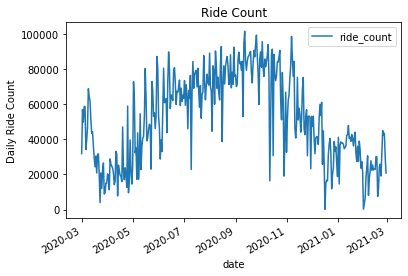

In [21]:
txt='Test'
ax = by_date.plot(y=['ride_count'], 
             title='Ride Count')

ax.set_ylabel("Daily Ride Count")
ax.set_xlabel("date")

plt.show()

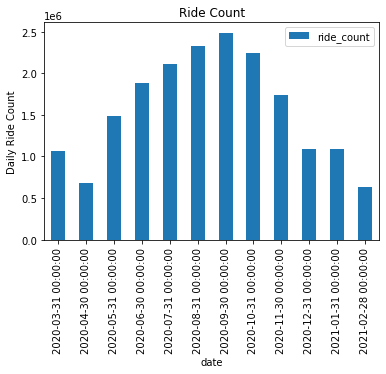

In [23]:
by_date_monthly = by_date.resample("M").sum()

ax = by_date_monthly.plot.bar(y=['ride_count'], 
             title='Ride Count')

ax.set_ylabel("Daily Ride Count")
ax.set_xlabel("date")

plt.show()

### Covid-19 Data Import & Cleaning

In [167]:
rides_cases = pd.merge(ny_df_diff, by_date, left_index=True, right_index=True)
rides_cases.head()

,cases,deaths,cases_SMA_7,deaths_SMA_7,ride_count,ride_count_SMA_7
2020-03-01,1.0,0.0,NaN,NaN,31878,NaN
2020-03-02,0.0,0.0,NaN,NaN,56946,NaN
2020-03-03,1.0,0.0,NaN,NaN,49723,NaN
2020-03-04,0.0,0.0,NaN,NaN,58670,NaN
2020-03-05,2.0,0.0,NaN,NaN,58686,NaN


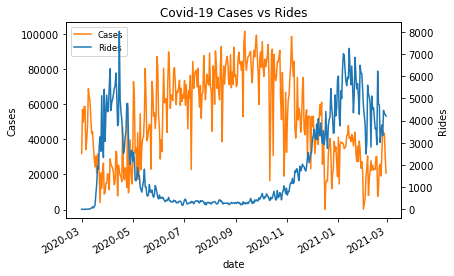

In [291]:
#plot cases vs rides

ax = rides_cases.plot(y='ride_count',
                      title='Covid-19 Cases vs Rides', 
                      label='Cases',
                     color='tab:orange')
ax1 = rides_cases.plot(y='cases',
                       secondary_y=True, 
                       ax=ax, 
                       label='Rides',
                      color='tab:blue')

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax1.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax.legend(lines, labels, loc='upper left', fontsize=8.5)
ax.set_ylabel('Cases')
ax1.set_ylabel('Rides')
ax.set_xlabel('date')

plt.show()

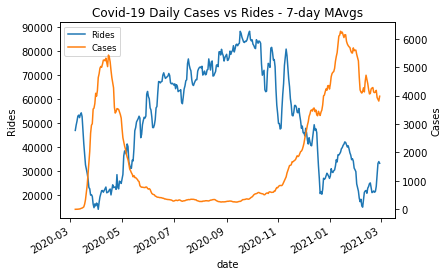

In [279]:
#plot cases vs rides with 7-day moving avgs
ax = rides_cases.plot(y='ride_count_SMA_7',
                      title='Covid-19 Daily Cases vs Rides - 7-day MAvgs', 
                      label='Rides')
ax1 = rides_cases.plot(y='cases_SMA_7',
                       secondary_y=True, 
                       ax=ax, 
                       label='Cases')

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax1.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax.legend(lines, labels, loc='upper left', fontsize=8.5)
ax.set_ylabel('Rides')
ax1.set_ylabel('Cases')
ax.set_xlabel('date')

plt.show()

In [290]:
#Run pierson correlation between rides & cases
corr_rides_cases = rides_cases.ride_count.corr(rides_cases.cases)
corr_rides_cases.round(5)

-0.67398

All in all, we did see indications that negative changes in CITIbike ridership tracked positive changes in the daily number of Covid-19 cases. The Pearson Correlation Coefficient for Rides and Cases over the period sampled was -0.67398, indicating a moderately strong negative relationship.